In [1]:
import torch
from torch.utils.data import Dataset
from torch.nn import functional as F
from torchvision import transforms
from torch.optim import AdamW

from diffusers import AutoencoderKL, UNet2DConditionModel, StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel

from peft import LoraConfig, get_peft_model
from bitsandbytes.optim import AdamW8bit


from PIL import Image, ImageOps
import gc
import os
from tqdm.auto import tqdm


# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "stabilityai/stable-diffusion-2-base"
torch_device = "cuda"

/home/parsa/miniconda3/envs/dbooth/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if False: # to be reproducible
    seed = 4
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# load stuff
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder",
)
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet"
)
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

#keep all models on GPU (unless specified otherwise)
text_encoder.to(torch_device)
vae = vae.to(torch_device)
unet = unet.to(torch_device)

In [4]:
# overloading the same data set for dreambooth
class MyDataset(Dataset):
    def __init__(self, data_dir, resolution=512, pre_load_images=True, class_of_obj=""):
        self.data_dir = data_dir
        self.resolution = resolution
        self.images=[]
        self.pre_load_images = pre_load_images
        self.class_of_obj = class_of_obj
        self.transform = transforms.Compose(
            [
                transforms.Resize(self.resolution),
                transforms.RandomCrop(self.resolution),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.images_names = os.listdir(data_dir)
        print(f"{self.__len__()} images in {data_dir}")
        if self.pre_load_images: #if its the dreambooth dataset, keep on ram (~4 images in total)
            self.__loadimages__()

        
    def __len__(self):
        return len(self.images_names)

    def __loadimages__(self):
        self.images = []
        for idx in range(len(self.images_names)):
            img_path = os.path.join(self.data_dir, self.images_names[idx])
            image = Image.open(img_path)  
            image = ImageOps.exif_transpose(image) # PIL kept rotating images randomly?

            self.images.append(image)

    def __getitem__(self, idx):
        if self.pre_load_images: # used for dreambooth dataset (which should be preloaded)
            return self.transform(self.images[idx])
        else: # used for pregenerated class dataset 
            img_path = os.path.join(self.data_dir, f"{self.class_of_obj}_{idx%(self.__len__())}.jpeg")
            image = Image.open(img_path)  
            image = ImageOps.exif_transpose(image)
            return self.transform(image)


In [5]:
batchsize = 1                           # <------------------------------------------args here
use_prior = [False, True][1]            # prior loss, needs the class img datasets to compare performance
weave_losses = [False, True][1]         # to increase memory efficency when using prior loss.
                                        # applies prior loss and regular loss one at a time
train_text = ["False","lora","True"][1]
unet_use_lora = [False, True][1]
rank = 50                               # lora rank
adam8bit = [False,True][0]              # use 8bit adam
total_train_steps = 1000
grad_accumilation = 1                   # accumulate gradients every x steps
# lr =  1e-4 if unet_use_lora else 5e-6   #lora uses bigger learning rates
lr = 1e-5
resolution = 512
class_of_obj = ["woman","dog"][0]                        

if not use_prior:
    weave_losses = False




prompt = [f"a photo of sks {class_of_obj}"]
text_tokens = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )
text_inputs = text_tokens.input_ids.to(torch_device)
if train_text == "False":
    with torch.no_grad():
        text_embeddings = text_encoder(text_inputs)[0]
        print("precomputed the text embedding")


my_dbs = ["dog_db","dorsa_rembg_db","hyeny_rembg_db","misha_db"][1]
ds = MyDataset(data_dir=f"./db/{my_dbs}", 
               pre_load_images=True,
               resolution=resolution)
dataloader = torch.utils.data.DataLoader(
        ds,
        batch_size=batchsize,
        shuffle=True,
        num_workers=1,
        # pin_memory=True,
    )

if use_prior:
    class_prompt = [f"a photo of {class_of_obj}"]
    class_text_tokens = tokenizer(
        class_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
        )
    class_text_inputs = class_text_tokens.input_ids.to(torch_device)

    if train_text == "False":
        with torch.no_grad():
            class_text_embeddings = text_encoder(class_text_inputs)[0]
            print("precomputed the class text embedding")

    model_versions = {"stabilityai/stable-diffusion-2-base":"v2-base",
                    "stabilityai/stable-diffusion-2-1":"v2-1"}
    class_dir = f"{model_versions[model_id]}_{resolution}"
    path_to_class_images = f"./class_pictures/class_{class_of_obj}/{class_dir}"

    class_ds = MyDataset(data_dir=path_to_class_images,
                        pre_load_images=False,
                        resolution=resolution, 
                        class_of_obj=class_of_obj)
    class_dataloader = torch.utils.data.DataLoader(
            class_ds,
            batch_size=batchsize,
            shuffle=True,
            num_workers=1,
            # pin_memory=True,
        )

5 images in ./db/dorsa_rembg_db
392 images in ./class_pictures/class_woman/v2-base_512


In [6]:
vae.requires_grad_(False)

if unet_use_lora:
    unet = unet.requires_grad_(False)
    print("using lora for unet")
    unet_lora_config = LoraConfig(
            r=rank,
            lora_alpha=rank,
            init_lora_weights="gaussian",
            target_modules=["to_k", "to_q", "to_v", "to_out.0", "add_k_proj", "add_v_proj"],
        )
    unet = get_peft_model(unet, unet_lora_config)
else:
    print("full unet training")
    unet = unet.requires_grad_(True)
unet.train()


if train_text == "lora":
    print("using lora for text encoder")
    text_encoder = text_encoder.requires_grad_(False)
    text_lora_config = LoraConfig(
            r=rank,
            lora_alpha=rank,
            init_lora_weights="gaussian",
            target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],
        )
    text_encoder = get_peft_model(text_encoder, text_lora_config)
    text_encoder.train()
elif train_text == "True":
    print("full text training")
    text_encoder = text_encoder.requires_grad_(True)
    text_encoder.train()
elif train_text == "False":
    print("text encoder is frozen")
    text_encoder = text_encoder.requires_grad_(False)
    text_encoder = text_encoder.to("cpu")
else:
    raise Exception("wtf is text encoder doing?")
    

using lora for unet
using lora for text encoder


In [7]:
trainable_params = []
for p in unet.parameters():
    if p.requires_grad:
        trainable_params.append(p)

for p in text_encoder.parameters():
    if p.requires_grad:
        trainable_params.append(p)

if adam8bit: 
    optim = AdamW8bit(trainable_params, lr=lr)
    print("using 8bit adam")
else:
    optim = AdamW(trainable_params, lr=lr)
    print("using adam")
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_train_steps, eta_min=lr/4)

using adam


In [8]:
def train_feed_forward(batch, timesteps, embeddings):
    with torch.no_grad():
        model_input = vae.encode(batch).latent_dist.sample()  # hmmm can i get the latent_dist only once and keep in memory?
        model_input = model_input * vae.config.scaling_factor # tried it, dont know how to handle the object.......need to try more

    noise = torch.randn_like(model_input, device=torch_device)

    noisy_images = scheduler.add_noise(model_input, noise, timesteps)

    if scheduler.config.prediction_type == "v_prediction":
        target = scheduler.get_velocity(model_input, noise, timesteps)
    else: 
        target = noise

    noise_pred = unet(noisy_images, timesteps, embeddings)[0]

    loss = F.mse_loss(noise_pred, target)
    return loss

In [9]:
epoch = 0

In [10]:
unet.train()
text_encoder.train()


grad_acc_counter = 0
total_epochs = int(total_train_steps/(len(dataloader)/grad_accumilation))

print(f"{"using prior class loss\n" if use_prior else ""}\
{"unet using lora" if unet_use_lora else "full unet training"}\n\
text training: {train_text}\n\
using {"8bit " if adam8bit else ""}adamw\n\
{"weaving losses \n" if weave_losses else ""}\
{total_train_steps} steps over {total_epochs} epochs")

pbar = tqdm(total=total_epochs)
while epoch<total_epochs:
    epoch+=1
    batch_losses = 0
    for step,batch in enumerate(dataloader):
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batchsize,), device=torch_device, dtype=torch.int64)

        batch = batch.to(torch_device)

        if train_text != "False":
            text_embeddings = text_encoder(text_inputs)[0]
        loss = train_feed_forward(batch, timesteps, text_embeddings)

        if weave_losses:
            loss.backward()

        if use_prior:
            class_batch = next(iter(class_dataloader))
            class_batch = class_batch.to(torch_device)

            if train_text != "False":
                class_text_embeddings = text_encoder(class_text_inputs)[0]
            prior_loss = train_feed_forward(class_batch, timesteps, class_text_embeddings)
            prior_loss = 1. * prior_loss
            
            if weave_losses:
                prior_loss.backward()
            loss = loss + prior_loss

        if not weave_losses:
            loss.backward()
        batch_losses += loss.item()

        grad_acc_counter+=1
        if grad_acc_counter==grad_accumilation:
            grad_acc_counter=0
            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
            optim.step()
            lr_scheduler.step()
            optim.zero_grad()

    pbar.set_description(f"epoch: {epoch}/{total_epochs} mean loss: {batch_losses/len(dataloader)} lr: {lr_scheduler.get_last_lr()[0]}")
    pbar.update(1)
        

using prior class loss
unet using lora
text training: lora
using adamw
weaving losses 
1000 steps over 200 epochs


epoch: 75/200 mean loss: 0.12100726095959544 lr: 7.685062871369205e-06:  38%|███▊      | 75/200 [08:31<14:08,  6.79s/it]

KeyboardInterrupt: 

In [11]:
optim.zero_grad()
noise = None
gc.collect()
torch.cuda.empty_cache()

In [12]:
unet.eval()
text_encoder.eval()
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               vae=vae,
                                               text_encoder=text_encoder,
                                               unet=unet,
                                               scheduler=scheduler,
                                               )
batch = None
gc.collect()
torch.cuda.empty_cache()
pipe = pipe.to(torch_device)

Expected types for text_encoder: ['CLIPTextModel'], got PeftModel.
Expected types for unet: ['UNet2DConditionModel'], got PeftModel.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 130.12it/s]


In [13]:
prompts = ["sks woman in a field of roses",
          "sks woman walking a dog",
          "sks woman fighting a demon",
          "sks woman with a very expensive purse",
          "sks woman wearing expensive shoes",
          "sks woman cleaning her room"
]
images = []
for pr in prompts:
    with torch.no_grad():
        images.append(pipe(pr).images[0])

100%|██████████| 50/50 [00:15<00:00,  3.28it/s]


sks woman cleaning her room


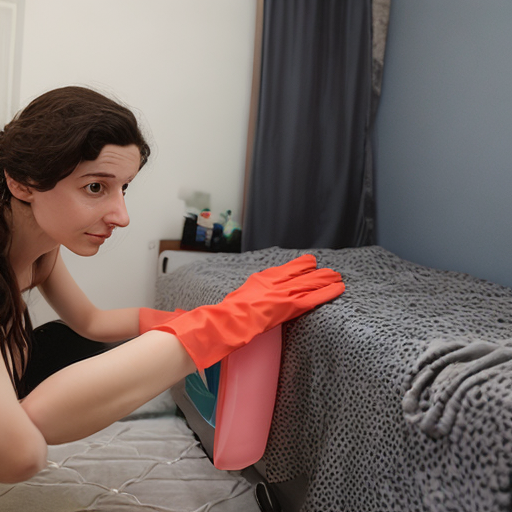

In [19]:
i=5
print(prompts[i])
images[i]

In [14]:
def save_models(model_name):
    unet.save_pretrained(f"../models/{model_name}/unet")
    text_encoder.save_pretrained(f"../models/{model_name}/text_encoder")
save_models("laptop_hyeny_1")

In [ ]:
def load_models():
    from peft import PeftModel
    new_unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
    new_unet = PeftModel.from_pretrained(new_unet, "../models/laptop_prior_1/unet/unet_lora")

    new_text = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
    new_text = PeftModel.from_pretrained(new_text,"../models/laptop_prior_1/text_encoder")

In [13]:
name = "test_1_no_prior"
unet.save_pretrained(f"./{name}/unet")
text_encoder.save_pretrained(f"./{name}/text_encoder")



# prompt = "sks"
# with torch.no_grad():
#     image = pipe(prompt, generator=generator).images[0]
# print("dorsa doing her homework")
# image